# Preprocessing
_Load, process, feature eng., save_

In [1]:
# initialise packages and meta-constants in this notebook
import numpy as np
import pandas as pd
PATH_TO_RAW_DATA = 'data\\raw\\'
PATH_TO_PROC_DATA = 'data\\interim\\'
LOAD_REQ = False

## Read.

Load Data. Traditional way

In [2]:
%%time
df = pd.read_csv(PATH_TO_RAW_DATA + 'RMS_Crime_Incidents.csv', low_memory=False)
df.head(3)

Wall time: 1.28 s


,X,Y,crime_id,report_number,address,offense_description,offense_category,state_offense_code,arrest_charge,charge_description,...,year,scout_car_area,precinct,block_id,neighborhood,council_district,zip_code,longitude,latitude,oid
0,-83.227700,42.372037,3106656,1708200056,Warwick St & Plymouth Rd,LARCENY - OTHER,LARCENY,2307,23007,LARCENY - OTHER,...,2017,0607,06,261635468002000,Franklin Park,7,48228,-83.227700,42.372037,23794854
1,-83.085641,42.388613,3048604,1704100012,Glynn Ct & Woodward Ave,ROBBERY,BURGLARY,2201,22001,BURGLARY - FORCED ENTRY,...,2017,1005,10,261635323001000,Boston Edison,5,48202,-83.085641,42.388613,23794855
2,-83.225292,42.372590,3473019,2002210298,Weaver St & Stahelin Ave,BURGLARY - FORCED ENTRY,BURGLARY,2201,22001,BURGLARY - FORCED ENTRY,...,2020,0604,06,261635469001016,Southfield Plymouth,7,48228,-83.225292,42.372590,23794856


Let's see the data.

In [3]:
df.columns

Index(['X', 'Y', 'crime_id', 'report_number', 'address', 'offense_description',
       'offense_category', 'state_offense_code', 'arrest_charge',
       'charge_description', 'incident_timestamp', 'incident_time',
       'day_of_week', 'hour_of_day', 'year', 'scout_car_area', 'precinct',
       'block_id', 'neighborhood', 'council_district', 'zip_code', 'longitude',
       'latitude', 'oid'],
      dtype='object')

In [4]:
df.loc[0]

X                                      -83.2277
Y                                        42.372
crime_id                                3106656
report_number                        1708200056
address                Warwick St & Plymouth Rd
offense_description             LARCENY - OTHER
offense_category                        LARCENY
state_offense_code                         2307
arrest_charge                             23007
charge_description              LARCENY - OTHER
incident_timestamp     2017-08-20T11:28:00.000Z
incident_time                             07:28
day_of_week                                   7
hour_of_day                                   7
year                                       2017
scout_car_area                             0607
precinct                                     06
block_id                        261635468002000
neighborhood                      Franklin Park
council_district                              7
zip_code                                

**Let's evaluate the time distribution available in a dataset of observations now**

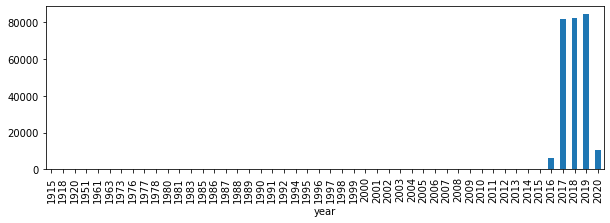

In [5]:
df.groupby('year').crime_id.count().plot.bar(figsize=(10, 3))

Let's slice only new years. As there are a limited number of observations before the 2016-2017 period, we will evaluate only 2016+ period

In [6]:
df = df[df.year >= 2016]

## Feature eng.

### Cats of crimes

There are a few **classifications of crimes** exist. We will take a look to label our crimes on _National Incident-Based Reporting System (NIBRS) user manual_:
```
Source (avaliable on feb 2020):
ucr-2019-1-nibrs-user-manual.pdf -> 
        * https://www.atlantapd.org/Home/ShowDocument?id=2881 
        * https://www.fbi.gov/file-repository/ucr/ucr-2019-1-nibrs-user-manual.pdf/view
```

We found, that this classification is use **3** types:
   * Offences against **person**
   * Offences against **society**
   * Offences against **property**
   
**On the other side**, we also might use the help from domain experts to make our classifications broader and to fit it on a certain problem.

Take a look at the categories used in our data.

In [7]:
cats = df.offense_category.unique()
cats

array(['LARCENY', 'BURGLARY', 'FRAUD', 'STOLEN VEHICLE', 'RUNAWAY',
       'OTHER', 'DAMAGE TO PROPERTY', 'ARSON', 'OBSTRUCTING THE POLICE',
       'HOMICIDE', 'JUSTIFIABLE HOMICIDE', 'KIDNAPPING', 'SEXUAL ASSAULT',
       'SEX OFFENSES', 'ASSAULT', 'AGGRAVATED ASSAULT', 'STOLEN PROPERTY',
       'DANGEROUS DRUGS', 'FAMILY OFFENSE', 'GAMBLING', 'LIQUOR',
       'WEAPONS OFFENSES', 'DISORDERLY CONDUCT', 'OUIL', 'MISCELLANEOUS',
       'ROBBERY', 'SOLICITATION', 'EXTORTION', 'FORGERY',
       'OBSTRUCTING JUDICIARY'], dtype=object)

Now to prepare  the relative `df` indexes of offenses according to our classification of crimes (type/category):

In [8]:
index_to_society = df.offense_category[df.offense_category.isin(\
        ['DANGEROUS DRUG', 'GAMBLING', 'WEAPONS OFFENSES'])].index

index_to_person = df.offense_category[df.offense_category.isin(\
        ['SEX OFFENSES', 'SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ASSAULT', 'AGGRAVATED ASSAULT'])].index

index_to_property = df.offense_category[df.offense_category.isin(\
        ['ARSON', 'LARCENY', 'BURGLARY', 'STOLEN VEHICLE', 'FRAUD', 
         'DAMAGE TO PROPERTY', 'STOLEN PROPERTY', 'ROBBERY', 'EXTORTION', 'FORGERY'])].index

# The list of classified as others/non-crimes
# OUIL, MISCELLANEOUS, OBSTRUCTING THE POLICE, JUSTIFIABLE HOMICIDE, FAMILY OFFENSE, 
# LIQUOR, DISORDERLY CONDUCT, OBSTRUCTING JUDICIARY

In [9]:
def process_cats():
    df['Crime Against'] = 'Another'
    df.loc[index_to_society, 'Crime Against'] = 'Society'
    df.loc[index_to_person, 'Crime Against'] = 'Person'
    df.loc[index_to_property, 'Crime Against'] = 'Property'   

In [10]:
%%time
process_cats()

Wall time: 203 ms


### Time
**Let's preprocess timestamps in the data**. We also need to set a proper a timezone.

In [11]:
def process_timestamps():
    # timezone
    df['incident_timestamp_dt'] = pd.to_datetime(df['incident_timestamp']).dt.tz_convert('America/Detroit')
    # times
    df['incident_timestamp_dt_month'] = df['incident_timestamp_dt'].dt.month
    df['incident_timestamp_dt_hour'] = df['incident_timestamp_dt'].dt.hour
    df['incident_timestamp_dt_day_of_week'] = df['incident_timestamp_dt'].dt.dayofweek
    df['incident_timestamp_dt_day_of_month'] = df['incident_timestamp_dt'].dt.day

In [12]:
%%time
process_timestamps()

Wall time: 776 ms


### Save

**Let's save the preprocessed data**.  
After that, it's ready to be loaded to cloud storage.

In [13]:
# memory usage of each column in bytes
memory_usege = df.memory_usage().sum() / (1024 * 1024)
print('App. file size is: {0} MB; shape of file is {1}, rows x cols;'.format(memory_usege.round(2), df.shape))
del memory_usege

App. file size is: 72.57 MB; shape of file is (264568, 30), rows x cols;


In [14]:
df.to_csv(PATH_TO_PROC_DATA + 'RMS_Crime_Incidents_modified.csv')

***

### Save to storage

**Let's load the preprocessed data to cloud storage**.  
After that, it would be ready to access from everywhere.

In [1]:
import pandas as pd
PATH_TO_PROC_DATA = 'data\\interim\\'

import src.db_connector
    
def load_to_storage(base_name : str ='crimes', collection_name : str ='example'):
    '''
    load elements from container to the cloud database.
    # PANDAS case example https://sricharanphp.blogspot.com/2020/01/insert-pandas-dataframe-into-mongodb.html
    
    :Parameters:
    
    input
        - :base_name: mongo's DATABASE name
        - :collection_name: mongo's DATABASE.COLLECTION name
    return
        - :None: inserted to DB data
    '''
    # prepare data
    df = pd.read_csv(PATH_TO_PROC_DATA + 'RMS_Crime_Incidents_modified.csv', 
                      index_col=0, low_memory=False)
    df.reset_index(inplace=True) # dangerous point
    print(df.shape)
    # load data
    mongo_string = src.db_connector.read_credentials()
    client = src.db_connector.db_connector(connect_mongo_string=mongo_string)
    db_database = client[base_name]
    collection = db_database[collection_name]
    
    src.db_connector.insert_many_items(collection=collection, container=df.to_dict("records")) # df.head(5)

In [2]:
%%time
LOAD_REQ = True
if LOAD_REQ == True:
    load_to_storage('crimes', 'detroit')

Wall time: 10min 18s


***